In [193]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


# 1. Defining the structure

We want to model a photonic crystal with lattice constant *a* = 0.420 microns. 
- radius = 0.3a
- wavelength range from 1.50 to 1.56 microns
- (x, y, z) dimensions = (15, 10, 0.26)
- refractive index = 3.23

For now, we ignore thickness and treat the crystal as a 2-dimensional structure. 

In [194]:
resolution = 20
a = 0.420
w = 15
h = 10
d = 0.26
r = 0.3 * a
default_material = mp.Medium(epsilon=10.4329)

def get_hole_centers(w, h, a, line_defect=False):
    horizontal_spacing = a * np.sqrt(3) / 2
    padding = 1.0

    h = h - padding
    w = w - padding

    num_rows = int(h // a)
    halfway_point = num_rows // 2

    start_x = -w / 2
    end_x = w / 2

    hole_centers = []

    for row in range(0, num_rows):
        if line_defect and row == halfway_point:
            continue

        y = (row - halfway_point) * a
        x = start_x
        if row % 2 == 1:
            x += horizontal_spacing / 2
        
        while x <= end_x:
            hole_centers.append((x, y))
            x += horizontal_spacing

    return hole_centers

sx = w + 4 
sy = h + 4 
cell = mp.Vector3(sx,sy,0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

hole_centers = get_hole_centers(w, h, a, line_defect=True)
holes = [mp.Cylinder(r, center=mp.Vector3(x, y), material=mp.air) 
         for x, y in hole_centers]
geometry = [mp.Block(size=mp.Vector3(w, h, mp.inf),
                     center=mp.Vector3(),
                     material=default_material),
                     *holes,
                     ]



Now we define a light source. This is a Gaussian source at the center of the device. What we really want here is a quantum dot source.  

In [195]:
fcen = 0.6666  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(),
                     size=mp.Vector3(0,a,0))]

     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
     cylinder, center = (-7,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.63627,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.27254,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.90881,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.54508,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.18135,-4.2,0)
          radius 0.126, height

          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.45389,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.09015,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     ...(+ 761 objects not shown)...


<Axes: xlabel='X', ylabel='Y'>

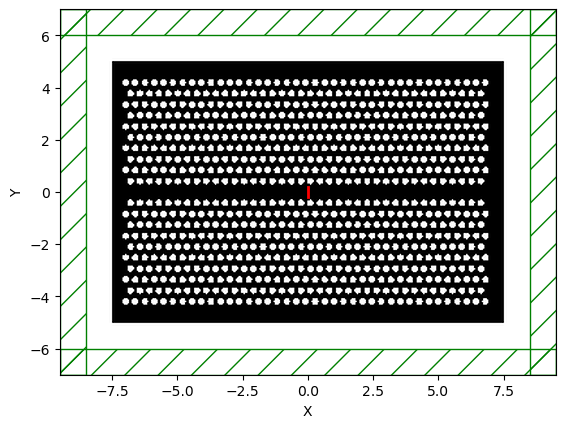

In [196]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)
sim.plot2D()

# 2. Get the Flux

Let's get the transmission spectrum at the right end of the waveguide, right before the edge of the cell. 

To do this, we need to determine the transmittance in the waveguide structure and normalize it by the incident power (computed by using the same point in a structure that only contains air).

First, we compute the transmittance from the structure itself. 

     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
     cylinder, center = (-7,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.63627,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.27254,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.90881,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.54508,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.18135,-4.2,0)
          radius 0.126, height

<Axes: xlabel='X', ylabel='Y'>

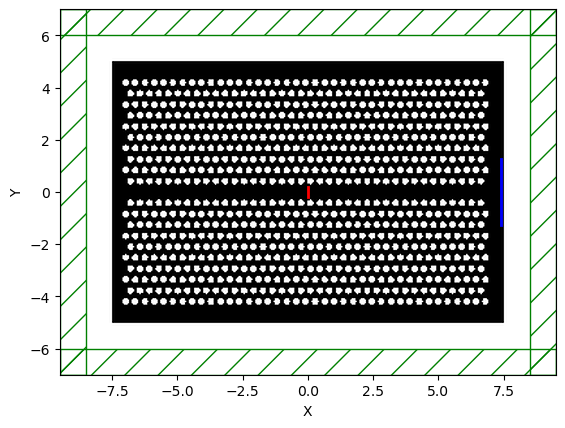

In [197]:
nfreq = 200  # number of frequencies at which to compute flux

# transmitted flux (across a 3a tall line, 0.1 micron from the right edge of the waveguide)
tran_fr = mp.FluxRegion(center=mp.Vector3(w / 2 - 0.1, 0, 0), size=mp.Vector3(0, h/4,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.plot2D()

In [198]:
pt = mp.Vector3(w / 2 + 0.1, h/4)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.0119529 s
Working in 2D dimensions.
Computational cell is 19 x 14 x 0 with resolution 20
     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
     cylinder, center = (-7,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.63627,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.27254,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.90881,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.54508,-4.2,0)
          radius 0.12

cylinder, center = (-4.45389,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.09015,-4.2,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     ...(+ 761 objects not shown)...
time for set_epsilon = 2.13356 s
-----------
field decay(t = 50.025000000000006): 2.8928226085583782e-09 / 2.8928226085583782e-09 = 1.0
field decay(t = 100.05000000000001): 7.862647985866e-05 / 7.862647985866e-05 = 1.0
on time step 4872 (time=121.8), 0.000821093 s/step
field decay(t = 150.07500000000002): 0.0005025128915063944 / 0.0005025128915063944 = 1.0
field decay(t = 200.10000000000002): 0.0004368888411777683 / 0.0005025128915063944 = 0.8694082252658167
field decay(t = 250.125): 7.291301233867609e-05 / 0.0005025128915063944 = 0.14509679964647887
on time step 10448 (time=261.2), 0.000717412 s/step
field decay(t = 300.15000000000003): 0.0001149181686481

In [199]:
waveguide_tran_flux = mp.get_fluxes(tran)

# 3. Get flux for a reference structure (all air)

For our reference transmittance, we define a cell with the same dimensions that only contains air. 

<Axes: xlabel='X', ylabel='Y'>

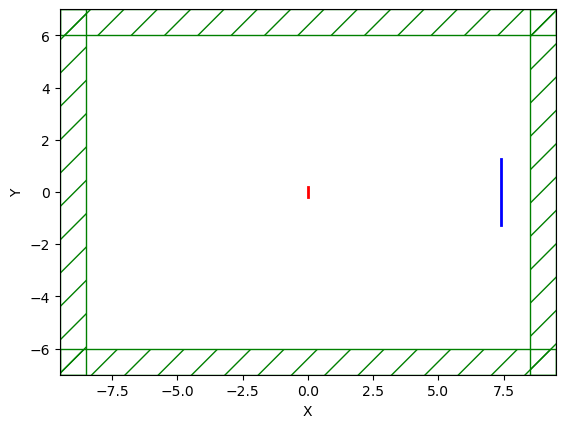

In [203]:
sim.reset_meep()
geometry = []
# geometry = [mp.Block(size=mp.Vector3(w, h, mp.inf),
#                      center=mp.Vector3(),
#                      material=default_material),
#                      ]
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)


tran_fr = mp.FluxRegion(center=mp.Vector3(w / 2 - 0.1, 0, 0), size=mp.Vector3(0,h/4,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)
sim.plot2D()

In [204]:
pt = mp.Vector3(w / 2 + 0.1, h/4)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,5e-3))

air_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 19 x 14 x 0 with resolution 20
time for set_epsilon = 0.138293 s
-----------
field decay(t = 50.025000000000006): 0.001767258737650784 / 0.001767258737650784 = 1.0
field decay(t = 100.05000000000001): 0.0036000726643467132 / 0.0036000726643467132 = 1.0
on time step 5707 (time=142.675), 0.000700987 s/step
field decay(t = 150.07500000000002): 5.2584177994451016e-11 / 0.0036000726643467132 = 1.4606421285664021e-08
run 0 finished at t = 150.07500000000002 (6003 timesteps)


# Plot the transmittance spectrum

In the following plot, transmittance is calculated by normalizing the waveguide transmittance flux by the air transmittance flux. Note that the transmittance sometimes goes above 1 because we are normalizing it by the flux in a region that likely gets less of that wavelength when there is no waveguide present. 

Is there a better reference to compare this against?

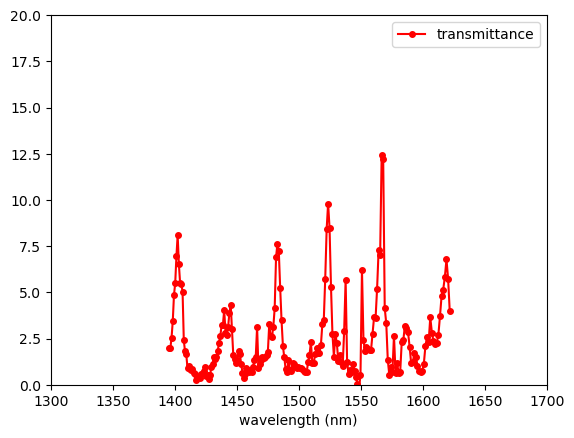

In [205]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1000 * 1/flux_freqs[i])
    Ts = np.append(Ts,waveguide_tran_flux[i]/air_tran_flux[i])

if mp.am_master():
    plt.figure()
    plt.plot(wl,Ts,'ro-',label='transmittance', markersize=4)
    plt.axis([1300, 1700, 0, 20])
    plt.xlabel("wavelength (nm)")
    plt.legend(loc="upper right")
    plt.show()